In [1]:
import sys
import os
import random
import gc
import time
import torch
import numpy as np
import pandas as pd
import ast
from tqdm import tqdm
from scipy.stats import spearmanr, pearsonr, kendalltau, rankdata
from sklearn.metrics import ndcg_score
from transformers import AutoModelForCausalLM, AutoTokenizer
from accelerate import Accelerator
os.environ["CUDA_VISIBLE_DEVICES"] = "3" 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.append(parent_dir)
from SHapRAG.rag_shap import *

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df= pd.read_csv("../data/synthetic_data/20_synergy_hard_negatives.csv",index_col=False, sep=";")
# df= pd.read_csv("../data/complementary.csv")

In [3]:
SEED = 42
# Initialize Accelerator
accelerator_main = Accelerator(mixed_precision="fp16")

# Load Model
if accelerator_main.is_main_process:
    print("Main Script: Loading model...")
# model_path = "mistralai/Mistral-7B-Instruct-v0.3"
model_path = "meta-llama/Llama-3.1-8B-Instruct"
# model_path = "Qwen/Qwen2.5-3B-Instruct"

model_cpu = AutoModelForCausalLM.from_pretrained(
    model_path,
    torch_dtype=torch.float16
)
tokenizer = AutoTokenizer.from_pretrained(model_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
    model_cpu.config.pad_token_id = tokenizer.pad_token_id
    if hasattr(model_cpu, 'generation_config') and model_cpu.generation_config is not None:
        model_cpu.generation_config.pad_token_id = tokenizer.pad_token_id

if accelerator_main.is_main_process:
    print("Main Script: Preparing model with Accelerator...")
prepared_model = accelerator_main.prepare(model_cpu)
unwrapped_prepared_model = accelerator_main.unwrap_model(prepared_model)
unwrapped_prepared_model.eval()
if accelerator_main.is_main_process:
    print("Main Script: Model prepared and set to eval.")

# Define utility cache

accelerator_main.wait_for_everyone()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Main Script: Loading model...


Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


Main Script: Preparing model with Accelerator...
Main Script: Model prepared and set to eval.


In [26]:
num_questions_to_run=len(df.question)
# num_questions_to_run=1
k_values = [1,2,3,4,5]
all_results=[]

# Define ground truth set of docs for precision (adapt as needed)
# e.g., if first 2 docs are always relevant
def get_gtset_k():
    return [0, 1,5]

for i in tqdm(range(num_questions_to_run), disable=not accelerator_main.is_main_process):
    query = df.question[i]
    if accelerator_main.is_main_process:
        print(f"\n--- Question {i+1}/{num_questions_to_run}: {query[:60]}... ---")

    p = ast.literal_eval(df.context[i])
    docs = p[:5] + [p[1]] + p[5:]
    utility_cache_base_dir = f"../Experiment_data/synthetic/{model_path.split('/')[1]}/duplicates"
    utility_cache_filename = f"utilities_q_idx{i}.pkl"
    current_utility_path = os.path.join(utility_cache_base_dir, utility_cache_filename)

    if accelerator_main.is_main_process:
        os.makedirs(os.path.dirname(current_utility_path), exist_ok=True)

    harness = ContextAttribution(
        items=docs,
        query=query,
        prepared_model=prepared_model,
        prepared_tokenizer=tokenizer,
        accelerator=accelerator_main,
        utility_cache_path=current_utility_path
    )

    if accelerator_main.is_main_process:
        methods_results = {}
        metrics_results = {}
        extra_results = {}

        m_samples_map = {"L": 364}

        # Store FM models for later R²/MSE
        fm_models = {}

        for size_key, num_s in m_samples_map.items():
            if 2 ** len(docs) < num_s and size_key != "L":
                actual_samples = max(1, 2 ** len(docs) - 1 if 2 ** len(docs) > 0 else 1)
            else:
                actual_samples = num_s

            if actual_samples > 0:
                methods_results[f"ContextCite{actual_samples}"], model_cc = harness.compute_contextcite(
                    num_samples=actual_samples, seed=SEED
                )

                attributions, _ = harness.compute_spex(sample_budget=actual_samples, max_order=2)
                methods_results[f"FBII{actual_samples}"] = attributions['fbii']
                methods_results[f"Spex{actual_samples}"] = attributions['fourier']
                methods_results[f"FSII{actual_samples}"] = attributions['fsii']

                # methods_results[f"FM_WeightsDU{actual_samples}"], Fdu, modelfmdu = harness.compute_wss(
                #     num_samples=actual_samples, seed=SEED, sampling="uniform",
                #     sur_type="fm", utility_mode="divergence_utility"
                # )
                # methods_results[f"FM_WeightsDK{actual_samples}"], Fdk, modelfmdk = harness.compute_wss(
                #     num_samples=actual_samples, seed=SEED, sampling="kernelshap",
                #     sur_type="fm", utility_mode="divergence_utility"
                # )
                methods_results[f"FM_WeightsLK{actual_samples}"], Flk, modelfmlk = harness.compute_wss(
                    num_samples=actual_samples, seed=SEED, sampling="kernelshap", sur_type="fm"
                )
                methods_results[f"FM_WeightsLU{actual_samples}"], Flu, modelfmlu = harness.compute_wss(
                    num_samples=actual_samples, seed=SEED, sampling="uniform", sur_type="fm"
                )

                # Save FM models
                fm_models.update({
                    # f"FM_WeightsDU{actual_samples}": modelfmdu,
                    # f"FM_WeightsDK{actual_samples}": modelfmdk,
                    f"FM_WeightsLK{actual_samples}": modelfmlk,
                    f"FM_WeightsLU{actual_samples}": modelfmlu
                })

                # Save extra Fs
                extra_results.update({
                    # "Fdu": Fdu,
                    # "Fdk": Fdk,
                    "Flk": Flk,
                    "Flu": Flu
                })

        methods_results["LOO"] = harness.compute_loo()
        methods_results["ARC-JSD"] = harness.compute_arc_jsd()

        # --- Evaluation Metrics ---
        metrics_results["topk_probability"] = harness.evaluate_topk_performance(
            methods_results, k_values, utility_type="probability"
        )
        metrics_results["topk_divergence"] = harness.evaluate_topk_performance(
            methods_results, k_values, utility_type="divergence"
        )
        metrics_results["topk_response_probability"] = harness.top_k_response_probability(
            methods_results, k_values=[1, 2,3]
        )

        # R² and MSE for ContextCite
        r2, mse = harness.r2_mse(30, 'logit-prob', model_cc, method='cc')
        metrics_results["R2_cc"] = r2
        metrics_results["MSE_cc"] = mse

        # R² and MSE for each FM method that has a model
        for method_name, fm_model in fm_models.items():
            r2, mse = harness.r2_mse(30, 'logit-prob', fm_model, method='fm')
            metrics_results[f"R2_{method_name}"] = r2
            metrics_results[f"MSE_{method_name}"] = mse

        # LDS per method
        LDS = {}
        for method_name, scores in methods_results.items():
            if "FM_WeightsLU" in method_name:
                LDS[method_name] = harness.lds(scores, 30, utl=True, model=modelfmlu)
            else:
                LDS[method_name] = harness.lds(scores, 30)
        metrics_results["LDS"] = LDS

        # Precision per method
        precision_scores = {}
        gtset_k = get_gtset_k()
        for method_name, scores in methods_results.items():
            precision_scores[method_name] = harness.precision(gtset_k, scores)
        metrics_results["precision"] = precision_scores

        harness.save_utility_cache(current_utility_path)

        all_results.append({
            "query_index": i,
            "query": query,
            "ground_truth": df.answer[i],
            "methods": methods_results,
            "metrics": metrics_results,
            "extra": extra_results
        })


  0%|          | 0/20 [00:00<?, ?it/s]


--- Question 1/20: What kind of energy does the facility hovering the planet Xy... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx0.pkl...
Successfully loaded 711 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 464898.49it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
  5%|▌         | 1/20 [00:09<02:56,  9.28s/it]

Main Process: Saving 712 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx0.pkl...
Save complete.

--- Question 2/20: What is the primary defense of the creatures populating the ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx1.pkl...
Successfully loaded 715 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 536635.03it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 10%|█         | 2/20 [00:19<03:00, 10.05s/it]

Main Process: Saving 716 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx1.pkl...
Save complete.

--- Question 3/20: What is the main function of the device recently discovered ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx2.pkl...
Successfully loaded 714 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 598481.64it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 15%|█▌        | 3/20 [00:29<02:49,  9.96s/it]

Main Process: Saving 714 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx2.pkl...
Save complete.

--- Question 4/20: What is the composition of the natural wonder of planet Ntun... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx3.pkl...
Successfully loaded 711 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 519294.78it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 20%|██        | 4/20 [00:40<02:41, 10.10s/it]

Main Process: Saving 711 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx3.pkl...
Save complete.

--- Question 5/20: What is the traditional weapon of the defenders of the Citad... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx4.pkl...
Successfully loaded 716 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 477699.20it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 25%|██▌       | 5/20 [00:50<02:32, 10.14s/it]

Main Process: Saving 716 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx4.pkl...
Save complete.

--- Question 6/20: What kind of power source is used by the ancient constructs ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx5.pkl...
Successfully loaded 710 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 522672.60it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 30%|███       | 6/20 [01:00<02:20, 10.06s/it]

Main Process: Saving 711 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx5.pkl...
Save complete.

--- Question 7/20: What is the primary ingredient of the most famous healing po... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx6.pkl...
Successfully loaded 709 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 537201.50it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 35%|███▌      | 7/20 [01:10<02:12, 10.19s/it]

Main Process: Saving 709 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx6.pkl...
Save complete.

--- Question 8/20: What defensive ability is possessed by the strongest creatur... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx7.pkl...
Successfully loaded 716 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 537012.54it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 40%|████      | 8/20 [01:21<02:04, 10.39s/it]

Main Process: Saving 716 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx7.pkl...
Save complete.

--- Question 9/20: What is the energy source of the massive orbital platform or... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx8.pkl...
Successfully loaded 719 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 488083.97it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 45%|████▌     | 9/20 [01:31<01:53, 10.29s/it]

Main Process: Saving 719 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx8.pkl...
Save complete.

--- Question 10/20: What is the population of the capital of the biggest country... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx9.pkl...
Successfully loaded 717 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 590609.92it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 50%|█████     | 10/20 [01:41<01:42, 10.24s/it]

Main Process: Saving 717 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx9.pkl...
Save complete.

--- Question 11/20: What's the weather like in the capital of Zhykara?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx10.pkl...
Successfully loaded 712 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 507049.70it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 55%|█████▌    | 11/20 [01:51<01:31, 10.22s/it]

Main Process: Saving 713 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx10.pkl...
Save complete.

--- Question 12/20: What's the value of the element obtained by mixing Aethelite... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx11.pkl...
Successfully loaded 718 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 538717.94it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 60%|██████    | 12/20 [02:02<01:22, 10.32s/it]

Main Process: Saving 719 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx11.pkl...
Save complete.

--- Question 13/20: What's the side effect of mixing Gravitium and Solara?... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx12.pkl...
Successfully loaded 717 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 551762.43it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 65%|██████▌   | 13/20 [02:13<01:14, 10.66s/it]

Main Process: Saving 718 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx12.pkl...
Save complete.

--- Question 14/20: What is the radius of the largest planet in the K'tharr Syst... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx13.pkl...
Successfully loaded 715 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 576340.75it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 70%|███████   | 14/20 [02:23<01:03, 10.52s/it]

Main Process: Saving 715 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx13.pkl...
Save complete.

--- Question 15/20: What is the population of the smallest planet in the Lumina ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx14.pkl...
Successfully loaded 709 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 563575.73it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 75%|███████▌  | 15/20 [02:34<00:53, 10.62s/it]

Main Process: Saving 710 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx14.pkl...
Save complete.

--- Question 16/20: What is the title of the latest film starring the highest-pa... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx15.pkl...
Successfully loaded 715 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 494406.30it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 80%|████████  | 16/20 [02:45<00:42, 10.66s/it]

Main Process: Saving 715 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx15.pkl...
Save complete.

--- Question 17/20: What is the salary of the most popular actor on the planet A... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx16.pkl...
Successfully loaded 712 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 500894.57it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 85%|████████▌ | 17/20 [02:56<00:32, 10.68s/it]

Main Process: Saving 712 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx16.pkl...
Save complete.

--- Question 18/20: What is the title of the first album by the most popular Chr... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx17.pkl...
Successfully loaded 712 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 581388.67it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 90%|█████████ | 18/20 [03:06<00:21, 10.56s/it]

Main Process: Saving 712 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx17.pkl...
Save complete.

--- Question 19/20: What is the total number of plays for the most critically ap... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx18.pkl...
Successfully loaded 717 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 537201.50it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
 95%|█████████▌| 19/20 [03:17<00:10, 10.60s/it]

Main Process: Saving 717 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx18.pkl...
Save complete.

--- Question 20/20: What is the effect of drinking water from the sacred spring ... ---
Main Process: Attempting to load utility cache from ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx19.pkl...
Successfully loaded 708 cached utility entries.


Computing utilities for ContextCite: 100%|██████████| 364/364 [00:00<00:00, 475023.85it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████| 20/20 [03:28<00:00, 10.42s/it]

Main Process: Saving 708 utility entries to ../Experiment_data/synthetic/Llama-3.1-8B-Instruct/duplicates/utilities_q_idx19.pkl...
Save complete.


In [27]:
import pandas as pd
import numpy as np
from collections import defaultdict

def summarize_and_print(all_results, k_values=[1, 3, 5]):
    table_data = defaultdict(lambda: defaultdict(list))

    # Mapping for consistency
    method_name_map = {
        "cc": "ContextCite364"  # rename cc to full name
    }

    for res in all_results:
        metrics = res["metrics"]

        # R² / MSE
        for key, val in metrics.items():
            if key.startswith("R2_") or key.startswith("MSE_"):
                raw_method = key.split("_", 1)[1]
                method = method_name_map.get(raw_method, raw_method)  # rename if needed
                metric_name = key.split("_", 1)[0]  # "R2" or "MSE"
                table_data[method][metric_name].append(val)

        # LDS
        for method_name, lds_val in metrics["LDS"].items():
            method = method_name_map.get(method_name, method_name)
            table_data[method]["LDS"].append(lds_val)

        # Precision
        for method_name, prec_val in metrics["precision"].items():
            method = method_name_map.get(method_name, method_name)
            table_data[method]["precision"].append(prec_val)

        # Top-k
        for metric_type in ["topk_probability", "topk_divergence", "topk_response_probability"]:
            for method_name, k_dict in metrics[metric_type].items():
                method = method_name_map.get(method_name, method_name)
                for k in k_values:
                    if k in k_dict:
                        col_name = f"{metric_type}_k{k}"
                        table_data[method][col_name].append(k_dict[k])

    # Averages
    avg_table = {
        method: {metric: np.nanmean(values) for metric, values in metric_dict.items()}
        for method, metric_dict in table_data.items()
    }

    df_summary = pd.DataFrame.from_dict(avg_table, orient="index").sort_index()

    print("\n=== Metrics Summary Across All Queries ===")
    print(df_summary.to_string(float_format="%.4f"))

    return df_summary


In [28]:
summarize_and_print(all_results, k_values=[1, 2,3])


=== Metrics Summary Across All Queries ===
                    R2     MSE    LDS  precision  topk_probability_k1  topk_probability_k2  topk_probability_k3  topk_divergence_k1  topk_divergence_k2  topk_divergence_k3  topk_response_probability_k1  topk_response_probability_k2  topk_response_probability_k3
ARC-JSD            NaN     NaN 0.6459     0.6500               7.8472              14.5633              17.6293              0.9888              1.6632              1.9504                        0.0611                        0.2323                        0.2292
ContextCite364  0.5541 12.9338 0.6526     0.8167               5.8124              19.0650              23.3668              0.7626              1.9608              2.5343                        0.1432                        0.2539                        0.3573
FBII364            NaN     NaN 0.4516     0.7333               4.6813              22.2729              27.6532              0.5579              2.3613              2.888

,R2,MSE,LDS,precision,topk_probability_k1,topk_probability_k2,topk_probability_k3,topk_divergence_k1,topk_divergence_k2,topk_divergence_k3,topk_response_probability_k1,topk_response_probability_k2,topk_response_probability_k3
ARC-JSD,NaN,NaN,0.645873,0.650000,7.847161,14.563280,17.629260,0.988758,1.663207,1.950366,0.061104,0.232282,0.229189
ContextCite364,0.554134,12.933758,0.652590,0.816667,5.812364,19.064976,23.366795,0.762605,1.960846,2.534305,0.143158,0.253874,0.357259
FBII364,NaN,NaN,0.451628,0.733333,4.681265,22.272854,27.653188,0.557927,2.361316,2.888791,0.151532,0.140769,0.214774
FM_WeightsLK364,0.903729,2.604352,0.621935,0.833333,5.380695,19.770020,23.433549,0.712828,2.035620,2.500316,0.151214,0.211000,0.348018
FM_WeightsLU364,0.930011,1.993655,0.818420,0.833333,5.911255,19.770020,23.734741,0.760292,2.035620,2.551312,0.143158,0.211000,0.359086
FSII364,NaN,NaN,0.451628,0.733333,4.681265,22.272854,27.653188,0.557927,2.361316,2.888791,0.151532,0.140769,0.214774
LOO,NaN,NaN,0.691168,0.566667,8.483532,10.310955,12.697930,0.943393,1.183694,1.409779,0.040218,0.183776,0.286169
Spex364,NaN,NaN,0.517301,0.833333,4.904935,21.882085,27.149069,0.575286,2.304134,2.822482,0.151532,0.169932,0.311339


In [29]:
import numpy as np
import matplotlib.pyplot as plt

def compute_recall_at_k(all_results, k_values=[1,2, 3,4, 5]):
    methods = list(all_results[0]["methods"].keys())
    recall_table = {m: [] for m in methods}

    for k in k_values:
        for method in methods:
            recalls = []
            for res in all_results:
                gt_indices = set([0,1,5])  # must exist in each result
                scores = np.array(res["methods"][method])
                topk_indices = set(scores.argsort()[-k:])
                hits = len(gt_indices & topk_indices)
                recalls.append(hits / len(gt_indices) if gt_indices else np.nan)
            recall_table[method].append(np.nanmean(recalls))
    return recall_table


def plot_recall_at_k(recall_table, k_values=[1,2, 3,4, 5]):
    plt.figure(figsize=(8, 5))
    for method, recalls in recall_table.items():
        plt.plot(k_values, recalls, marker="o", label=method)
    plt.xlabel("k")
    plt.ylabel("Recall@k")
    plt.title("Recall@k for All Methods")
    plt.xticks(k_values)
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.show()


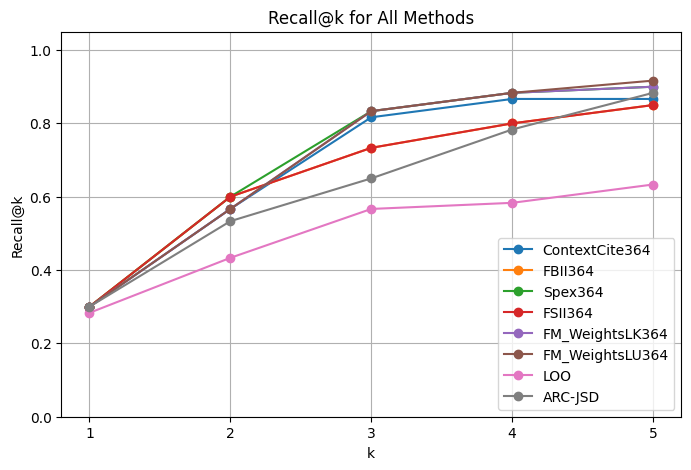

In [30]:
recall_table=compute_recall_at_k(all_results, k_values=[1, 2, 3, 4, 5])
plot_recall_at_k(recall_table, k_values=[1, 2, 3, 4, 5])